In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
from sklearn.datasets import load_diabetes

In [4]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [8]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
# Число деревьев в ансамбле
n_tree = 30

# для простоты примем коэффициенты равными 1
coefs = [1] * n_tree

# Максимальная глубина деревьев
max_depth = 4

# Шаг
eta = 0.2

trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [11]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_tree} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [12]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 644.7575676062193
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3626.983227532738


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа 

---

итераций.

In [13]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [14]:
import matplotlib.pyplot as plt

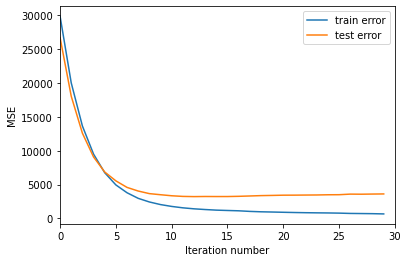

In [15]:
get_error_plot(n_tree, train_errors, test_errors)

### Задание 1:
Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.


In [16]:
def get_n_trees_error_plot(n_trees, train_err, test_err):
    plt.xlabel('n_trees')
    plt.ylabel('MSE')
    plt.xlim(n_trees[0], n_trees[-1])
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [17]:
# Максимальная глубина деревьев
max_depth = 4
# Шаг
eta = 0.2
# Число деревьев в ансамбле
n_trees = [5, 10, 15, 20, 25, 30, 50]
train_last_errors = []
test_last_errors = []

In [18]:
for n_tree in n_trees:
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_last_errors.append(train_errors[-1])
    test_last_errors.append(test_errors[-1])

Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 4951.221949158835
Ошибка алгоритма из 5 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 5551.085864020684
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 1774.0128357177193
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3348.9363480608636
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 1175.496776747453
Ошибка алгоритма из 15 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3235.013650128338
Ошибка алгоритма из 20 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 909.1069412902701
Ошибка алгоритма из 20 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3434.2333207212014
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 783.9786569126367
Ошибка алгоритма из 25 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3505.8155986

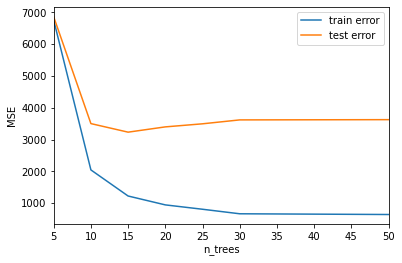

In [19]:
get_n_trees_error_plot(n_trees, train_last_errors, test_last_errors)

При колчестве деревьев выше 15 ошибка на тестовой выборке не уменьшается, а переобучение только увеличивается.

In [20]:
def get_depth_error_plot(max_depths, train_err, test_err):
    plt.xlabel('max depth')
    plt.ylabel('MSE')
    plt.xlim(max_depths[0], max_depths[-1])
    plt.plot(max_depths, train_err, label='train error')
    plt.plot(max_depths, test_err, label='test error')
    plt.legend(loc='center right')
    plt.show()

In [21]:
# Число деревьев в ансамбле
n_tree = 20
# Шаг
eta = 0.2
# Максимальная глубина деревьев
max_depths = [2, 3, 4, 5, 6, 7, 8]
train_last_errors = []
test_last_errors = []

In [22]:
for max_depth in max_depths:
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_last_errors.append(train_errors[-1])
    test_last_errors.append(test_errors[-1])

Ошибка алгоритма из 20 деревьев глубиной 2     с шагом 0.2 на тренировочной выборке: 2166.7734226248813
Ошибка алгоритма из 20 деревьев глубиной 2     с шагом 0.2 на тестовой выборке: 2916.4376211683502
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.2 на тренировочной выборке: 1541.3115184981552
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.2 на тестовой выборке: 3036.097347448995
Ошибка алгоритма из 20 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 909.1069412902701
Ошибка алгоритма из 20 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3434.2333207212014
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.2 на тренировочной выборке: 368.0100368884071
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.2 на тестовой выборке: 3579.1719448319054
Ошибка алгоритма из 20 деревьев глубиной 6     с шагом 0.2 на тренировочной выборке: 137.3711560164108
Ошибка алгоритма из 20 деревьев глубиной 6     с шагом 0.2 на тестовой выборке: 3814.012

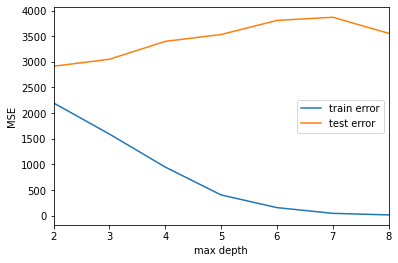

In [23]:
get_depth_error_plot(max_depths, train_last_errors, test_last_errors)

Увеличение глубины только увеличивает ошибку.
Для градиентного бустинга нужны простые модели

### Задание 2: (опция).
Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [24]:
# случайная подвыборка
def get_subsample(X, y, rate=0.5):
    shuffled = np.append(X, np.copy(y).reshape(len(y), 1), axis=1)
    np.random.shuffle(shuffled)
    i_slice = int(rate * len(X))
    return shuffled[: i_slice, :-1], shuffled[: i_slice, -1]

In [25]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subsample=0.5):

    # Деревья будем записывать в список
    trees = []

    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        #
        X_shuffled, y_shuffled = get_subsample(X_train, y_train, rate=subsample)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль,
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_shuffled, y_shuffled)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_shuffled, trees, coefs, eta)

            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_shuffled, bias(y_shuffled, target))

        train_errors.append(mean_squared_error(y_shuffled, gb_predict(X_shuffled, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)

    return trees, train_errors, test_errors

In [26]:
# Число деревьев в ансамбле
n_tree = 30

# для простоты примем коэффициенты равными 1
coefs = [1] * n_tree

# Максимальная глубина деревьев
max_depth = 4

# Шаг
eta = 0.2

trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [27]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.2 на тренировочной выборке: 791.6663134999254
Ошибка алгоритма из 30 деревьев глубиной 4     с шагом 0.2 на тестовой выборке: 3595.6087840296054


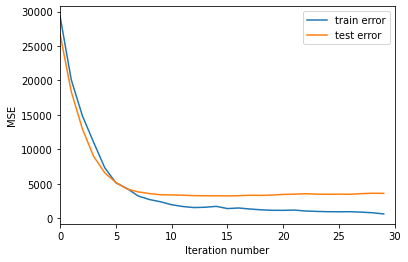

In [28]:
get_error_plot(n_tree, train_errors, test_errors)

почти тот же результат за меньшее время, выгода есть